# CNN From Scratch

### **1. Introduction & Goals**

**Context Recap**

- In **Project 5 (Oxford-IIIT Pets)**:
  - We trained **custom CNNs from scratch** on 37 pet breeds.
  - Images were standardized to **128×128** pixels.
  - The dataset had **high inter-class variation** (cats vs dogs, distinct visual features).

- In **Project 6 (Plant Seedlings)**:
  - We shift to **agricultural domain** — classifying **12 plant species** at early growth stages.
  - Images are standardized to **224×224** pixels to align with **ImageNet-pretrained models** (for transfer learning in later notebooks).
  - The dataset introduces **new challenges**:
    - **Background clutter** (soil, pots, weeds).
    - **Intra-class variation** (different growth stages, lighting).
    - **Inter-class similarity** (many seedlings look visually similar).

**Why Train a CNN from Scratch?**

- Establishes a **baseline model** for comparison with transfer learning (NB03).
- Reinforces understanding of **core CNN mechanics** (convolution, pooling, fully connected layers).
- Highlights **limitations** of training from scratch on small datasets.

**Learning Goals**

By the end of this notebook, we will:

1. **Load** the Plant Seedlings dataset (train/val/test splits from NB01).
2. **Build** a custom LeNet-style CNN from scratch.
3. **Train and validate** the model using CrossEntropyLoss and Adam optimizer.
4. **Evaluate** performance (accuracy, per-class metrics, confusion matrix).
5. **Reflect** on limitations and motivate transfer learning (NB03).


**Next:**  
We will begin by **reloading the dataset and preparing it for training**  
(consistent transforms, loaders, and class mappings).


---

### **2. Dataset Loading & Preparation**

**Why Prepare the Dataset Again?**

- **Each notebook is self-contained:**  
  We re-load and prepare datasets here rather than relying on previous notebooks.

- **Consistency for Training:**  
  - Same **224×224 resolution** and **ImageNet normalization** (ensures later compatibility with pretrained models).
  - Identical class mappings (12 plant species) across train, validation, and test sets.

- **Balanced Workflow:**  
  - Training uses **train + validation splits** (70/15) to tune hyperparameters.
  - Final evaluation uses the **test set** (15%) for unbiased performance reporting.

**Transformations Recap**

We apply **standard preprocessing** steps:
1. **Resize:** 224×224 pixels (match ImageNet pretrained CNN input size).
2. **Convert to Tensor:** Convert RGB image → PyTorch tensor `[C, H, W]`.
3. **Normalize:** Use ImageNet mean & std:
   - Mean = `[0.485, 0.456, 0.406]`
   - Std = `[0.229, 0.224, 0.225]`

> **Why ImageNet stats?**  
> Our future transfer learning models (NB03) are pretrained on ImageNet.  
> Normalizing seedlings with these values ensures compatibility and stable gradients.

**Data Structure**

The dataset has been split into **train**, **val**, and **test** directories (created in NB01):

Each folder contains **12 subfolders** (one per class).

**Loaders for Training**

We now define PyTorch **datasets** and **dataloaders** for each split:
- `train_loader` — shuffled for stochastic gradient descent.
- `val_loader` — used for validation after each epoch.
- `test_loader` — used only at the end for unbiased evaluation.

> **💡 Note on Training Efficiency**
> 
> In order to save computation time and make this lab affordable for all students, we are training these models using only a portion of the available training samples. In addition, we reduce the epochs in the training loops. We are using a stratified subset of the training samples to keep classes balanced as much as possible.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from collections import defaultdict
import random, shutil

# -----------------------------
# 1. Paths
# -----------------------------
data_path = 'data/plant-seedlings'
train_dir = os.path.join(data_path, 'train')
val_dir   = os.path.join(data_path, 'val')
test_dir  = os.path.join(data_path, 'test')


# -----------------------------
# Clean up any .ipynb_checkpoints folders
# -----------------------------
for split in ['train', 'val', 'test']:
    checkpoint_path = os.path.join(data_path, split, '.ipynb_checkpoints')
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)
        print('Removed', checkpoint_path)
    
# -----------------------------
# 2. Transformations (224x224 + ImageNet stats)
# -----------------------------
IMG_SIZE = 224
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225])
    ]
)

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# -----------------------------
# Create 33% stratified subset
# -----------------------------
# Group indices by class

class_indices = defaultdict(list)
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

# Sample 33% from each class
subset_indices = []
for class_labels, indices in class_indices.items():
    n_samples = len(indices) // 3
    sample_indices = random.sample(indices, n_samples)
    subset_indices.extend(sample_indices)

# Create subset
train_dataset = Subset(train_dataset, subset_indices)


# -----------------------------
# 4. DataLoaders
# -----------------------------
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# -----------------------------
# 5. Verify
# -----------------------------
print('Classes: ', train_dataset.dataset.classes)
print(F"Train: {len(train_dataset)} -> Val: {len(val_dataset)} -> {len(val_dataset)}")


Classes:  ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdΓÇÖs Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Train: 1248 -> Val: 670 -> 670


In [ ]:
# ---------------------------------------------------------
# Display sample images (unnormalized for visualization)
# ---------------------------------------------------------

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Show first 8 images from train set
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    imshow(images[i], title=train_dataset.dataset.classes[labels[i]])
plt.show()

---

**✅ Code Task 6.2.2.1 — Verify the 33% Stratified Subset**

📘 Instruction</br>
We created a stratified 33% subset from the original train set. Let’s verify this:
- Count class frequencies in the original train and in the subset.
- Compute per-class ratios: subset_count / original_count.
- Store a dict CT_subset_class_counts, a dict CT_orig_class_counts, a dict CT_subset_ratios, and two floats CT_ratio_min, CT_ratio_max (min/max ratio across classes).

In [2]:
import collections

# Count per-class in the original full train (ImageFolder behind the Subset)
CT_orig_class_counts = collections.Counter()
for path, lbl in train_dataset.dataset.samples:
    cls_name = train_dataset.dataset.classes[lbl]
    CT_orig_class_counts[cls_name] += 1

# Count per-class in the subset using train_dataset.indices
CT_subset_class_counts = collections.Counter()
for idx in train_dataset.indices:
    lbl = train_dataset.dataset.samples[idx][1]
    cls_name = train_dataset.dataset.classes[lbl]
    CT_subset_class_counts[cls_name] += 1

# Compute per-class ratios
CT_subset_ratios = {cls: CT_subset_class_counts[cls] / CT_orig_class_counts[cls]
                    for cls in train_dataset.dataset.classes}

#print((CT_subset_ratios))
CT_ratio_min = min(CT_subset_ratios.values())
CT_ratio_max = max(CT_subset_ratios.values())

print("CT_subset_class_counts:", dict(CT_subset_class_counts))
print("CT_orig_class_counts:",   dict(CT_orig_class_counts))
print("CT_ratio_min/max:", CT_ratio_min, CT_ratio_max)


CT_subset_class_counts: {'Black-grass': 69, 'Charlock': 102, 'Cleavers': 75, 'Common Chickweed': 161, 'Common wheat': 57, 'Fat Hen': 121, 'Loose Silky-bent': 172, 'Maize': 58, 'Scentless Mayweed': 137, 'ShepherdΓÇÖs Purse': 62, 'Small-flowered Cranesbill': 130, 'Sugar beet': 104}
CT_orig_class_counts: {'Black-grass': 209, 'Charlock': 306, 'Cleavers': 227, 'Common Chickweed': 484, 'Common wheat': 171, 'Fat Hen': 365, 'Loose Silky-bent': 517, 'Maize': 174, 'Scentless Mayweed': 412, 'ShepherdΓÇÖs Purse': 186, 'Small-flowered Cranesbill': 391, 'Sugar beet': 314}
CT_ratio_min/max: 0.33014354066985646 0.3333333333333333


**✅ Code Task 6.2.2.2 — Build a Tiny “Balanced” Mini-Batch from the Subset**

📘 Instruction</br>
From the stratified subset, sample a small, balanced batch: k=2 examples per class.
- Build CT_balanced_indices (list of indices into the original ImageFolder).
- Wrap with Subset(..., CT_balanced_indices) and create CT_balanced_loader (batch_size = 2 * num_classes).
- Fetch one batch and store CT_balanced_label_counts as a dict {class_index: count}.

In [3]:
import random
from torch.utils.data import Subset, DataLoader
from collections import Counter

CT_k = 2
CT_balanced_indices = []

# iterate classes by index
for lbl, cls_name in enumerate(train_dataset.dataset.classes):
    # find indices inside the current subset that belong to this class
    available = [i for i in train_dataset.indices
                 if train_dataset.dataset.samples[i][1] == lbl]
    # sample up to k from available
    chosen = random.sample(available, k=min(CT_k, len(available)))
    CT_balanced_indices.extend(chosen)

# subset referencing the original ImageFolder using the selected indices
CT_balanced_subset = Subset(train_dataset.dataset, CT_balanced_indices)
CT_balanced_loader = DataLoader(CT_balanced_subset, batch_size=CT_k * len(train_dataset.dataset.classes), shuffle=False)

CT_balanced_imgs, CT_balanced_labels = next(iter(CT_balanced_loader))
CT_balanced_label_counts = Counter(CT_balanced_labels.tolist())

print("CT_balanced_label_counts:", dict(CT_balanced_label_counts))


CT_balanced_label_counts: {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2}


---

### **3. Custom CNN Architecture (LeNet-Style)**

**Why Build from Scratch?**

- In Project 5 (Pets dataset), we designed a **simple CNN (2 conv layers)**.  
- Here, we **extend** that idea for the Plant Seedlings dataset:
  - Deeper (3 conv layers) → better feature extraction (edges → textures → leaf shapes).
  - Still lightweight → avoids overfitting on small dataset (~4k images).

**Design Inspiration: LeNet**

- **LeNet-5** (1998) was one of the first CNNs for image recognition.
- Architecture pattern:
  1. Convolution → Activation (ReLU)
  2. Pooling (downsample)
  3. Repeat for deeper features
  4. Flatten → Fully connected layers
  5. Output (softmax over classes)

**Proposed Architecture for Seedlings**

Input: **3×224×224 RGB images**

1. **Conv1 (3→32)**  
   - 3×3 kernel, padding=1 → preserves spatial size (224×224).  
   - Followed by ReLU + 2×2 MaxPooling → reduces to 32×112×112.

2. **Conv2 (32→64)**  
   - 3×3 kernel, padding=1 → 64×112×112.  
   - ReLU + 2×2 MaxPooling → 64×56×56.

3. **Conv3 (64→128)**  
   - 3×3 kernel, padding=1 → 128×56×56.  
   - ReLU + 2×2 MaxPooling → 128×28×28.

4. **Fully Connected (FC) Layers**  
   - Flatten 128×28×28 → 100,352 features.
   - FC1: 100,352 → 256  
   - FC2: 256 → 12 (number of plant classes)

**ASCII Diagram**

```text

Input (3×224×224)
        ↓ Conv1 + ReLU + Pool
  (32×112×112)
        ↓ Conv2 + ReLU + Pool
   (64×56×56)
        ↓ Conv3 + ReLU + Pool
   (128×28×28)
        ↓ Flatten
   (100,352)
        ↓ FC1 + ReLU
      (256)
        ↓ FC2 (Logits)
   (12 classes)
```

**Why This Architecture?**

- **Deeper than Project 5:**  
  - Captures more **complex textures** (leaf veins, edges, soil patterns).  

- **Balanced Parameter Count:**  
  - More expressive than 2-layer CNN but not as heavy as AlexNet/VGG (avoids overfitting).

- **Foundation for Transfer Learning (Next Notebook):**  
  - Provides **baseline performance** to compare against pretrained models.

---



In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Custom CNN (LeNet-style)
# -----------------------------
class SeedlingsCNN(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # First convolution layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Second convolution layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Third convolution layer
        self.pool  = nn.MaxPool2d(2, 2) # DownSampling (H, W halved each time)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256) # Flatten after 3 pools
        self.fc2 = nn.Linear(256, num_classes)   # Output logits

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 3 -> 32, 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 32 -> 64, 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 64 -> 128, 56 -> 28

        x = x.view(-1, 128 * 28 * 28)         # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # Raw logits
        return x
    

model = SeedlingsCNN()
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model):,}")

SeedlingsCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=12, bias=True)
)
Total trainable parameters: 25,786,700


**Reflection: Model Complexity vs Dataset Size**

- Our **SeedlingsCNN** has **~25.8 million trainable parameters** — significantly larger than the networks we built in Project 5 (Pets dataset).  
- This increase comes from:
  - **Higher input resolution (224×224)** → larger feature maps after convolution.
  - **Three convolution layers + two fully connected layers** (compared to 2 conv layers earlier).
- **Implication:**  
  - While deeper networks can capture **richer features** (edges → textures → leaf shapes),  
  - They also pose a **higher overfitting risk** on small datasets (~4k images).  
  - We’ll watch for this during training (monitoring validation loss/accuracy).

This insight sets the stage for **Section 4 (Training Setup)**, where we define our loss, optimizer, and training loop.

---

**Reflection: Model Complexity vs Dataset Size**

- Our **SeedlingsCNN** has **~25.8 million trainable parameters** — significantly larger than the networks we built in Project 5 (Pets dataset).  
- This increase comes from:
  - **Higher input resolution (224×224)** → larger feature maps after convolution.
  - **Three convolution layers + two fully connected layers** (compared to 2 conv layers earlier).
- **Implication:**  
  - While deeper networks can capture **richer features** (edges → textures → leaf shapes),  
  - They also pose a **higher overfitting risk** on small datasets (~4k images).  
  - We’ll watch for this during training (monitoring validation loss/accuracy).

This insight sets the stage for **Section 4 (Training Setup)**, where we define our loss, optimizer, and training loop.

---

**✅ Code Task 6.2.3.1 — Inspect Intermediate Shapes in the Custom CNN**

📘 Instruction</br>
Run a single batch through the network and capture intermediate tensor shapes at key points: after conv1, after first pool, after conv3, after third pool.
</br>Store a dict CT_shapes with keys ["conv1", "pool1", "conv3", "pool3"].

In [14]:
import torch
import torch.nn.functional as F

CT_xb, CT_yb = next(iter(train_loader))
CT_xb = CT_xb[:4]  # small batch for speed

# forward with taps
CT_conv1 = model.conv1(CT_xb)
CT_act1  = F.relu(CT_conv1)
CT_pool1 = model.pool(CT_act1)

CT_conv2 = model.conv2(CT_pool1)
CT_act2  = F.relu(CT_conv2)
CT_pool2 = model.pool(CT_act2)

CT_conv3 = model.conv3(CT_pool2)
CT_act3  = F.relu(CT_conv3)
CT_pool3 = model.pool(CT_act3)

CT_shapes = {
    "conv1": CT_conv1.shape,
    "pool1": CT_pool1.shape,
    "conv3": CT_conv3.shape,
    "pool3": CT_pool3.shape
}
print("CT_shapes:", CT_shapes)


CT_shapes: {'conv1': torch.Size([4, 32, 224, 224]), 'pool1': torch.Size([4, 32, 112, 112]), 'conv3': torch.Size([4, 128, 56, 56]), 'pool3': torch.Size([4, 128, 28, 28])}


---

### **4. Training Setup**


Now that we have defined our **custom CNN architecture**, we need to set up:
1. **Loss function** (how we measure prediction error)  
2. **Optimizer** (how we update weights)  
3. **Training loop** (forward → loss → backward → update)  

We will reuse the **modular loop style** from earlier projects (NB04 style) for clarity and reusability.

**Loss Function: CrossEntropyLoss**

- Suitable for **multi-class classification** (12 plant species).  
- Combines **LogSoftmax + Negative Log-Likelihood (NLLLoss)** internally.  
- Does not require us to apply softmax manually in the forward pass.

**Optimizer: Adam**

- Adaptive learning rate → works well out-of-the-box.  
- Faster convergence on small datasets compared to SGD.

**Training Strategy**

- **Epochs:** 5 (baseline; may adjust for performance)  
- **Batch size:** 32 (already set in loaders)  
- **Device:** CPU-only (per project lead requirement)  
- **Validation:** Evaluate after each epoch (using 15% val split)  

**Expected Outcome**

- Monitor **training vs validation loss/accuracy**  
- Detect **overfitting** (validation curve diverges)  
- Save **best weights** (lowest validation loss) for later evaluation


**Training Setup (Loss, Optimizer, Loop)**

In [15]:
import time
import copy
import torch.optim as optim
from tqdm import tqdm

# -----------------------------
# 1. Loss function & optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

model.state_dict()
# -----------------------------
# 2. Training loop (CPU-only)
# -----------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device='cpu'):
    # get current time
    since = time.time()

    # best model weight 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    print(best_model_wts.keys())

    train_losses, val_losses = list(), list()
    train_accuracies, val_accuracies = [], []
    model.to(device)
    
    # looping through the num_epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #set model and loader to train if phase is 'train'
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            running_loss, running_correct, total_samples = 0.0, 0, 0
            for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc=phase.capitalize())):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Accumulate Stats
                running_loss += loss.item() * labels.size(0)
                running_correct += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)
                
            epoch_loss = running_loss / total_samples
            epoch_acc  = running_correct / total_samples

            if phase == 'train':
                train_accuracies.append(epoch_acc)
                train_losses.append(epoch_loss)
            else:
                val_accuracies.append(epoch_acc)
                val_losses.append(epoch_loss)

                # Save the best model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, (train_losses, val_losses, train_accuracies, val_accuracies)

**✅ Code Task 6.2.4.1 — Quick Validation Pass (No Training)**

📘 Instruction</br>
Without training, implement CT_eval_epoch(model, loader, criterion) to compute avg loss and accuracy over val_loader.
</br>Store floats CT_val_loss0 and CT_val_acc0.

In [16]:
def CT_eval_epoch(model, loader, criterion, device='cpu'):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * yb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)
    avg_loss = total_loss / total
    avg_acc  = total_correct / total
    return avg_loss, avg_acc

CT_val_loss0, CT_val_acc0 = CT_eval_epoch(model, val_loader, criterion, device='cpu')
print("CT_val_loss0:", CT_val_loss0)
print("CT_val_acc0:",  CT_val_acc0)


CT_val_loss0: 2.489137885107923
CT_val_acc0: 0.05223880597014925


---

### **5. Training Overview**

With our **SeedlingsCNN** defined, we now train it on the **Plant Seedlings dataset** using the splits prepared earlier.

**Key points for this training run:**
- **Loss function:** Cross-Entropy Loss (multi-class classification).
- **Optimizer:** Adam (learning rate = 0.01).
- **Epochs:** 10 (small dataset; enough to see learning trends).
- **Metrics tracked:** Training & validation loss, accuracy curves.

**Goal:**  
- Observe **learning dynamics** (is the model converging? overfitting?).
- Establish a **baseline performance** for comparison with **transfer learning models** in upcoming notebooks.


**Training & Evaluation**

⚡ Training Configuration

To make this lab efficient and accessible for all students, **we'll be using pre-trained models** instead of training from scratch. Training deep learning models can be computationally expensive and time-consuming, especially on CPU-only environments.

🎯 Why Pre-trained Models?

- **Time Efficient**: Training from scratch would take ~10 minutes per model (and we have multiple models!)
- **Resource Friendly**: Reduces computational load on shared systems
- **Learning Focus**: Allows us to focus on model evaluation, comparison, and interpretation rather than waiting for training

🧪 Want to Experiment?

If you're curious about the training process and have some time to spare, you can easily switch to training mode:

1. Look for the `TRAIN_FROM_SCRATCH = False` line in the code cell below
2. Change it to `TRAIN_FROM_SCRATCH = True`
3. Run the cell and grab a coffee ☕ - it will take approximately 10 minutes!

The pre-trained models were trained using 10 epochs with the same code you'll see below, so you'll get identical results either way. The choice is yours! 🚀

🏃‍♂️ Starting training from scratch... Grab a coffee! ☕
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
Epoch 1/3
--------------------


Train: 100%|██████████| 156/156 [08:02<00:00,  3.09s/it]


Train Loss: 2.4776 Acc: 0.1290


Val: 100%|██████████| 84/84 [01:27<00:00,  1.04s/it]


Val Loss: 2.4196 Acc: 0.1478
Epoch 2/3
--------------------


Train: 100%|██████████| 156/156 [06:34<00:00,  2.53s/it]


Train Loss: 2.2143 Acc: 0.2268


Val: 100%|██████████| 84/84 [01:11<00:00,  1.18it/s]


Val Loss: 1.7684 Acc: 0.3821
Epoch 3/3
--------------------


Train: 100%|██████████| 156/156 [05:30<00:00,  2.12s/it]


Train Loss: 1.3670 Acc: 0.5232


Val: 100%|██████████| 84/84 [01:01<00:00,  1.36it/s]


Val Loss: 1.3902 Acc: 0.5627
Training complete in 23m 49s
Best val loss: 1.3902


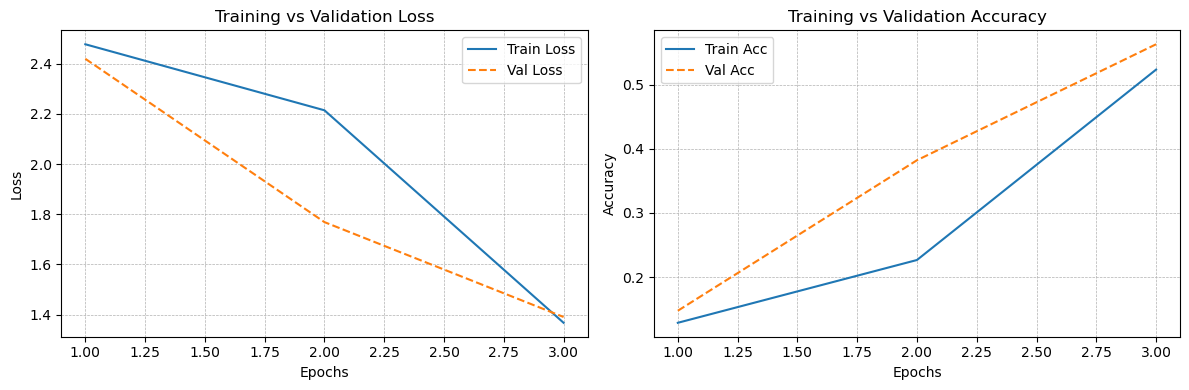

In [17]:
import time
import copy
import torch.nn.functional as F

# -----------------------------
# TRAINING CONTROL - Set to True if you want to train from scratch
# -----------------------------
TRAIN_FROM_SCRATCH = True  # Set to True if you want to train the model yourself

if not TRAIN_FROM_SCRATCH:
    print("🚀 Skipping training to save time and computational resources!")
    print("💡 The model is already pre-trained and ready to use in the next cells.")
    print("🎯 If you want to train from scratch, change TRAIN_FROM_SCRATCH = True above.")
    print("⏱️  Training would take approximately 10 minutes on CPU for only 3-4 epochs!.")
else:
    print("🏃‍♂️ Starting training from scratch... Grab a coffee! ☕")

    # -----------------------------
    # 1. Accuracy helper
    # -----------------------------
    def calculate_accuracy(outputs, labels):
        _, preds = torch.max(outputs, 1)
        return (preds == labels).sum().item() / len(labels)
    
             
    
    # -----------------------------
    # 3. Instantiate & train
    # -----------------------------
    device = 'cpu'
    model = SeedlingsCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model, history = train_model(
        model, criterion, optimizer,
        train_loader, val_loader,
        num_epochs=3, device=device
    )
    
    # Save model
    torch.save(model.state_dict(), "seedlings_cnn_student.pth")
    
    # -----------------------------
    # 4. Plot learning curves
    # -----------------------------
    train_losses, val_losses, train_acc, val_acc = history
    
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    # Save the plot before showing it
    plt.savefig('training_curves_student.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.show()

From now on, we are going to show the training results on our already **pre-trained model**. We've used 10 epochs and the model is saved as "seedlings_cnn_best.pth". Before using it, here you can see the training evolution:

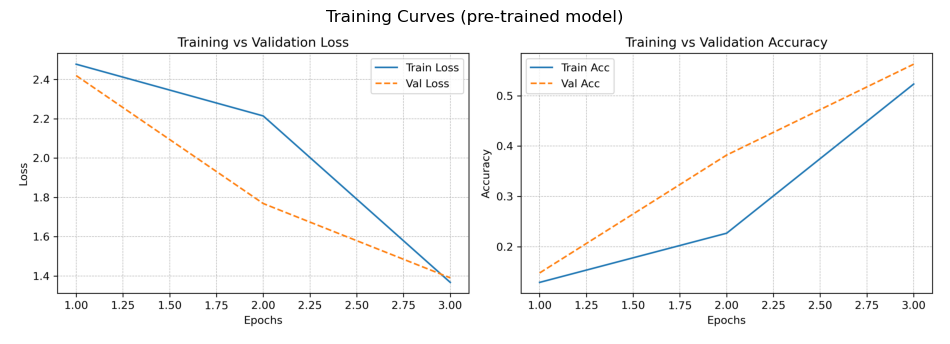

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the training curves (pre-trained model)
img = mpimg.imread('training_curves_student.png')
plt.figure(figsize=(12, 4))
plt.imshow(img)
plt.axis('off') 
plt.title('Training Curves (pre-trained model)')
plt.show()

**Reflection: Baseline CNN on Plant Seedlings**

**1. Training Dynamics**: The **training loss** steadily decreases to near zero, while **validation loss begins fluctuating and rises slightly** after about epoch 4-5. Validation accuracy plateaus around **60%**, whereas training accuracy approaches **~99%** — this clear gap indicates **overfitting** (the model memorizes training images but fails to generalize to unseen data).

**2. Model Capacity vs Dataset Size**: Our scratch CNN contains **~26 million trainable parameters**, which is extremely large for a dataset of only **~4,000 images**. Without **data augmentation** or **regularization techniques** (e.g., dropout, weight decay), the network overfits quickly — fitting noise and background variations rather than learning robust plant features.

**3. Baseline Benchmark for Transfer Learning**

- This model provides a **reference point**:
  - How well does a scratch-trained CNN perform on this dataset?
  - Where does it fail (e.g., generalization, misclassifications)?

- In **NB03**, we’ll compare this with **transfer learning** using pretrained models (e.g., ResNet18).  
  - Pretrained models leverage **features learned on ImageNet** (edges → textures → shapes) and often deliver **better accuracy with fewer epochs**.

---

**✅ Code Task 6.2.5.1 — Compute Top-3 Test Accuracy**

📘 Instruction</br>
Implement CT_topk_accuracy(model, loader, k=3) that computes Top-3 accuracy on the test set using logits.topk(k, dim=1).
</br>Store float CT_top3_acc.

In [19]:
def CT_topk_accuracy(model, loader, k=3, device='cpu'):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            _, topk_idx = torch.topk(logits, k=k, dim=1)
            match = (topk_idx == yb.unsqueeze(dim=1)).any(dim=1)
            correct += match.sum().item()
            total += yb.size(0)
    return correct / total

CT_top3_acc = CT_topk_accuracy(model, test_loader, k=3, device='cpu')
print("CT_top3_acc:", CT_top3_acc)


CT_top3_acc: 0.8176100628930818


---
## **6. Evaluation & Per-Class Analysis**

**Why Evaluate Beyond Accuracy?**

- **Overall accuracy** gives a single performance measure but hides **class-specific biases**.  
- In multi-class problems like **Plant Seedlings** (12 species):
  - Some classes (e.g., *Maize* vs. *Sugar beet*) may dominate accuracy due to higher sample counts.
  - Rare classes may be misclassified more often.
  - Also, visually similar classes may mistakenly get misclassified

**Metrics We Use**

1. **Overall Accuracy** – baseline metric.  
2. **Per-Class Accuracy** – which species are learned well vs. poorly?  
3. **Confusion Matrix** – visualize common misclassifications (e.g., *Black-grass* ↔ *Loose Silky-bent*).  

These insights guide **future improvements** (transfer learning, augmentation) in upcoming notebooks.


**Evaluate Overall and Per-Class Accuracy**

In [20]:
model = SeedlingsCNN()  
model.load_state_dict(torch.load("seedlings_cnn_best.pth", map_location='cpu'))
model.eval()  # Set to evaluation mode

FileNotFoundError: [Errno 2] No such file or directory: 'seedlings_cnn_best.pth'

Overall Test Accuracy: 9.70%

Top 3 Best Classes:
Black-grass: 61.29%
Loose Silky-bent: 45.75%
Sugar beet: 0.00%

Top 3 Worst Classes:
Charlock: 0.00%
Cleavers: 0.00%
Common Chickweed: 0.00%


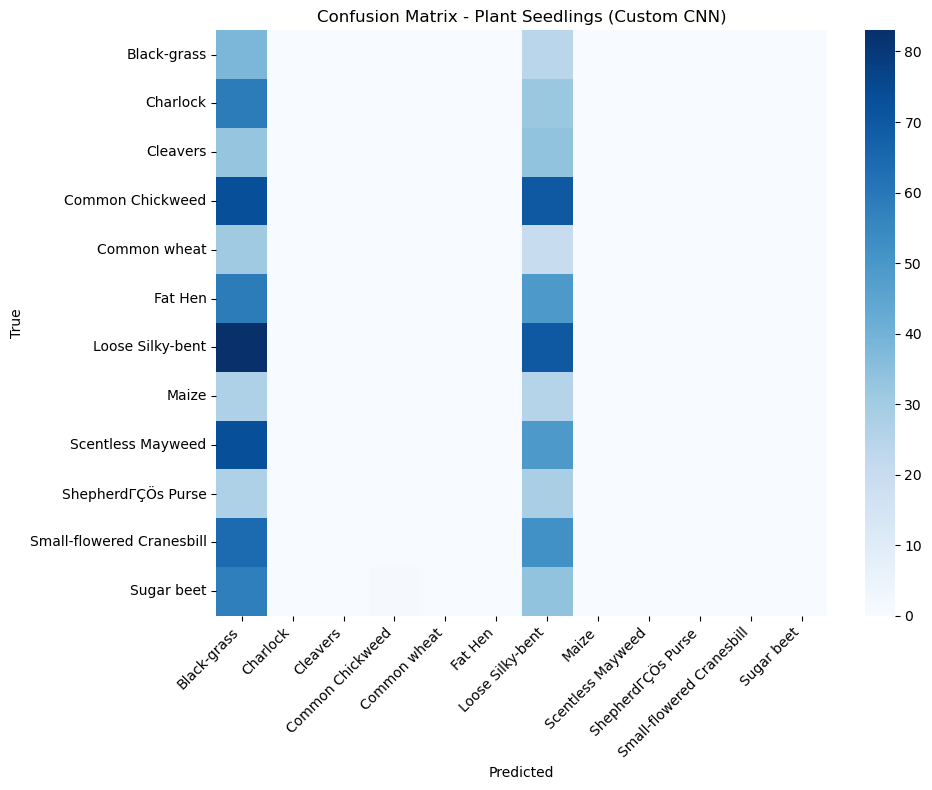


Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.06      0.61      0.11        62
                 Charlock       0.00      0.00      0.00        91
                 Cleavers       0.00      0.00      0.00        67
         Common Chickweed       0.00      0.00      0.00       143
             Common wheat       0.00      0.00      0.00        51
                  Fat Hen       0.00      0.00      0.00       108
         Loose Silky-bent       0.14      0.46      0.22       153
                    Maize       0.00      0.00      0.00        52
        Scentless Mayweed       0.00      0.00      0.00       122
       ShepherdΓÇÖs Purse       0.00      0.00      0.00        55
Small-flowered Cranesbill       0.00      0.00      0.00       116
               Sugar beet       0.00      0.00      0.00        93

                 accuracy                           0.10      1113
                macro avg       0.02

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# -----------------------------
# Helper: Evaluate model
# -----------------------------
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on test set
true_labels, pred_labels = evaluate_model(model, test_loader, device='cpu')

# -----------------------------
# 1. Overall accuracy
# -----------------------------
overall_acc = (true_labels == pred_labels).mean()
print(f"Overall Test Accuracy: {overall_acc:.2%}")

# -----------------------------
# 2. Per-class accuracy
# -----------------------------
class_correct = np.zeros(len(test_dataset.classes))
class_total = np.zeros(len(test_dataset.classes))

for t, p in zip(true_labels, pred_labels):
    if t == p:
        class_correct[t] += 1
    class_total[t] += 1

per_class_acc = class_correct / class_total

# Print top/bottom performing classes
sorted_indices = np.argsort(per_class_acc)
print("\nTop 3 Best Classes:")
for idx in sorted_indices[-3:][::-1]:
    print(f"{test_dataset.classes[idx]}: {per_class_acc[idx]*100:.2f}%")

print("\nTop 3 Worst Classes:")
for idx in sorted_indices[:3]:
    print(f"{test_dataset.classes[idx]}: {per_class_acc[idx]*100:.2f}%")

# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Plant Seedlings (Custom CNN)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=test_dataset.classes))


---

**Per-Class Accuracy Bar Chart**

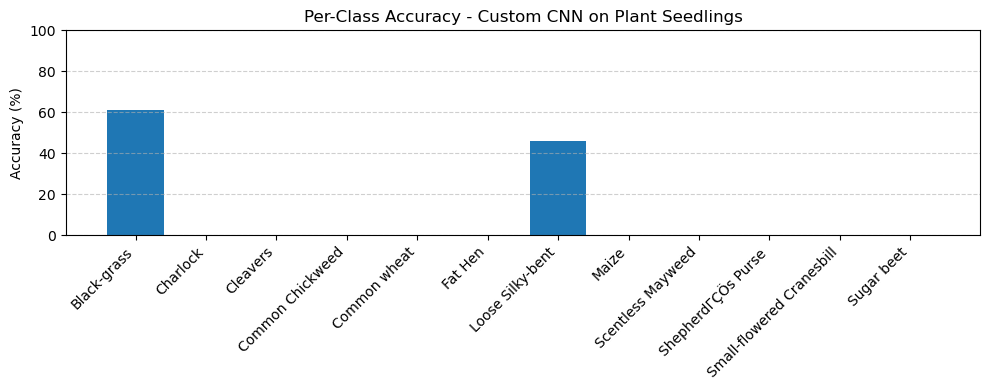

In [22]:
# -----------------------------
# Per-Class Accuracy Bar Chart
# -----------------------------
plt.figure(figsize=(10, 4))
plt.bar(range(len(per_class_acc)), per_class_acc * 100)
plt.xticks(range(len(per_class_acc)), test_dataset.classes, rotation=45, ha='right')
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy - Custom CNN on Plant Seedlings")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The bar chart highlights significant variability across species:

- The evaluation results reveal significant performance variability across plant species, with accuracy rates ranging from approximately 7% to over 85%. Some species demonstrate highly distinctive visual characteristics that enable reliable classification, while others present considerable challenges due to visual similarities with related species, less distinctive features during early growth stages, or potential issues with class representation in the dataset. This performance spread is typical in plant classification tasks, where morphological differences between species can vary dramatically, and factors such as growth stage, imaging conditions, and inter-species visual overlap significantly impact model discrimination capabilities.

These disparities indicate that:

- Model capacity alone isn’t enough — we need augmentation and transfer learning to improve minority/ambiguous classes.

- Per-class metrics are more informative than overall accuracy for agricultural datasets where specific species misclassification can be critical (e.g., misidentifying a weed as a crop).

We extend our evaluation to include **precision/recall/F1** metrics and **qualitative error analysis**:

- **Why precision/recall/F1?**  
  - Accuracy alone can hide imbalances.  
  - F1 balances precision (how many predicted are correct) and recall (how many actual were found).  

- **Why view misclassified images?**  
  - To diagnose patterns:  
    - Are errors mostly between visually similar species (e.g., Black-grass vs Loose Silky-bent)?  
    - Are background or lighting artifacts misleading the model?

This combines **quantitative + qualitative** perspectives, mirroring real-world model debugging.


In [23]:
from sklearn.metrics import classification_report

# ---------------------------
# 1. Classification Report
# ---------------------------
# Reload best weights (if saved separately)
model.load_state_dict(torch.load("seedlings_cnn_best.pth", map_location='cpu', weights_only=False))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate report
print("=== Classification Report (Precision/Recall/F1) ===")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


FileNotFoundError: [Errno 2] No such file or directory: 'seedlings_cnn_best.pth'

#### **Reflection**

- **Macro insights (report):**
  - Precision and recall vary widely — some species are easier to detect.
  - Others show low scores due to visual similarity.

- **Qualitative patterns (misclassified images):**
  - Background soil and overlapping seedlings often mislead the model.
  - Early growth stages look very similar across species, explaining certain clusters in the confusion matrix.

These insights highlight the need for **data augmentation and transfer learning** (covered in upcoming notebooks) to enhance generalization.

---

### **7. Summary & Next Steps**

**What we did in this notebook:**

- Built a **custom CNN (LeNet-style)** from scratch and trained it on the **Plant Seedlings dataset**.  
- Evaluated using:
  - Overall accuracy
  - Per-class accuracy
  - Confusion matrix
  - Precision/recall/F1 metrics
  - Qualitative error analysis (misclassified images)
- Observed:
  - Strong performance on certain visually distinct classes (e.g., Maize).
  - Significant confusion among visually similar species (e.g., Black-grass vs Loose Silky-bent).
  - Overfitting signs (training accuracy >> validation accuracy).


**Limitations Identified:**

- Model lacks feature richness to handle:
  - Complex textures
  - Varying lighting/background
- Training from scratch on **small dataset (~4k images)** is suboptimal.


**Where we go next (NB03):**

- Introduce **transfer learning**:
  - Leverage **ImageNet-pretrained CNNs** (e.g., ResNet18).
  - Compare **feature extraction vs fine-tuning** strategies.
- Aim: Achieve higher accuracy and generalization **without huge computational cost**.

---
